# mise en place des data

In [27]:
%matplotlib notebook

In [2]:
from sklearn.pipeline import Pipeline
from sklearn import decomposition
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets, linear_model, cross_validation, grid_search
from sklearn.metrics import confusion_matrix
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import pandas as pd
import pickle
from sklearn.pipeline import make_pipeline

/home/tbacoyannis/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/tbacoyannis/.local/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
%run ./configure.ipynb

In [4]:
pca = decomposition.PCA()
RFC= RandomForestClassifier()
estimators = [('reduce_dim', pca), ('Random_Forest', RFC)]

In [5]:
pipe = Pipeline(estimators)

In [6]:
cc=[70, 80, 90]
nb_tree=[200, 200, 200]
random_st=[0, 0, 0]

In [7]:
params = dict(reduce_dim__n_components=cc,
              Random_Forest__n_estimators=nb_tree,Random_Forest__random_state=random_st)

In [8]:
grid_search = GridSearchCV(pipe, param_grid=params)

In [33]:
# import some data
filename_Features_two_blocs=projectpath+'io/Output/Features_two_blocs.npy'
TRAIN=np.load(filename_Features_two_blocs)

# Import the dataFrame
Data_FRAMES=pd.read_pickle(projectpath+'io/Output/Dataframe_.pkl')

In [10]:
def Get_true_y(DF):
    " Get the real class "
    y=np.zeros([DF.shape[0]])
    for j in range(0,DF.shape[0]):
        if (DF.TYPE[j]==1):
            y[j]=1
        elif (DF.TYPE[j]==2):
            y[j]=2
        else :
            y[j]=3
        yr=(y.reshape(-1,1)).ravel() 
            #yr = yr.ravel()   
    return(yr)

In [11]:
# get the real class label
yr=Get_true_y(Data_FRAMES)

In [12]:
filename_yr =projectpath+'io/Output/yr.npy'

In [13]:
np.save(filename_yr, yr)

In [14]:
yr=np.load(filename_yr)

In [34]:
grid_search.fit(TRAIN, yr)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('reduce_dim', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('Random_Forest', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_node...imators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'Random_Forest__random_state': [0, 0, 0], 'Random_Forest__n_estimators': [200, 200, 200], 'reduce_dim__n_components': [70, 80, 90]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [35]:
print(grid_search.best_estimator_)

Pipeline(steps=[('reduce_dim', PCA(copy=True, iterated_power='auto', n_components=80, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('Random_Forest', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=...stimators=200, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False))])


In [37]:
# save the best parameters values
RDF_best_Param=grid_search.best_estimator_.named_steps['Random_Forest'].n_estimators
PCA_best_Param=grid_search.best_estimator_.named_steps['reduce_dim'].n_components

In [39]:
PCA_best_Param

80

In [52]:
pca=decomposition.PCA(n_components=PCA_best_Param, svd_solver='auto')
RFC=RandomForestClassifier(n_estimators=RDF_best_Param, max_features=PCA_best_Param, random_state=0)
clf_pca= make_pipeline(pca)
clf_RFC= make_pipeline(RFC)
clf_pca.fit(TRAIN)
m=clf_pca.transform(TRAIN)
clf_RFC.fit(m, yr)

Pipeline(steps=[('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=80, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False))])

In [105]:
#s_RFC = pickle.dumps(clf_RFC)
#s_PCA = pickle.dumps(clf_pca)

In [53]:
from sklearn.externals import joblib
joblib.dump(clf_pca, 'clf_pca.pkl')
joblib.dump(clf_RFC, 'clf_RFC.pkl')

['clf_RFC.pkl']

In [56]:
clf_RFC.predict(m)

array([ 2.,  2.,  2., ...,  3.,  3.,  3.])

In [47]:
predictedVAL = cross_val_predict(clf_RFC, m, yr , n_jobs =-1)

In [48]:
metrics.accuracy_score(yr, predictedVAL) 

0.93077148723965974

In [49]:
Conf_Mat=confusion_matrix(yr, predictedVAL)

<IPython.core.display.Javascript object>


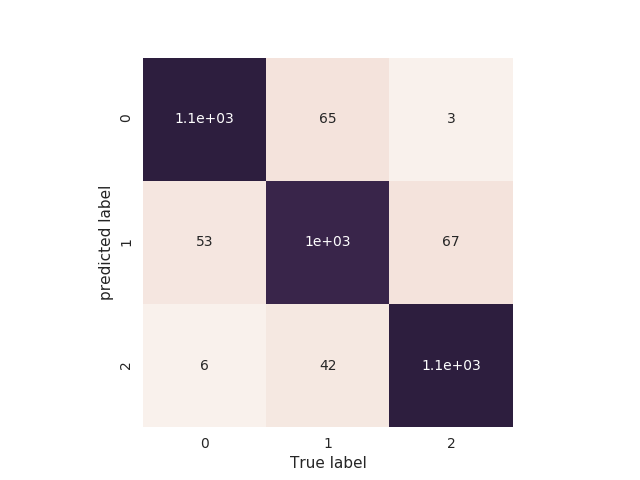

In [50]:
#%matplotlib inline
import seaborn as sns
sns.heatmap(Conf_Mat.T, square=True, annot=True, cbar=False)
plt.xlabel('True label')
plt.ylabel('predicted label');